In [1]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
batch_size = 1000
embedding_size = 4
time_steps = 101
category = 2
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


Using TensorFlow backend.


In [2]:
def reverse_complement(sequence):
    retseq = ''
    for k in range(len(sequence)-1, -1, -1):
        if sequence[k] == 'A':
            retseq = retseq + 'T'
        elif sequence[k] == 'T':
            retseq = retseq + 'A'
        elif sequence[k] == 'C':
            retseq = retseq + 'G'
        elif sequence[k] == 'G':
            retseq = retseq + 'C'
        else:
            retseq = retseq + sequence[k]

    """
    print("Revese:")
    print(sequence)
    print(retseq)
    print()
    """
    return retseq


In [3]:
print("Preprocessing Data:")
file_read = open("../imgtvgene_sequence_classification/naive.txt")

source_sequence = []
target_sequence = []

max_count = 200000
max_source_len = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    try:
        source = [char_to_int[x] for x in split[2][1:-1]]
        if max_source_len < len(source):
            max_source_len = len(source)

        seq = [char_to_int[x] for x in split[3][1:-1] if x in "NACGT"]
        target = [x * int(i < len(seq)) for (i, x) in enumerate(source)]
        
        assert(len(target) == len(source))
    except:
        print("Exceptions")
        continue
        
    source_sequence.append(source)
    target_sequence.append(target)
    
    vgene_name = split[-1][1:-1].split("*")[0]
    #* for Gene /- for Family /No Split for Allele
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    #print(split[1], vgene_name)
    if count == max_count:
        break
    
print(len(source_sequence), max_source_len, len(target_sequence))
print(len(vgene_tag), vgenes)


Preprocessing Data:
200000 507 200000
200000 58


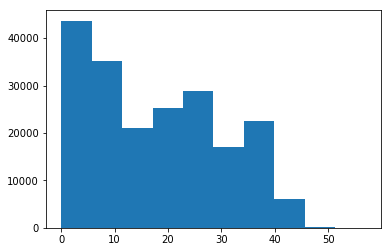

In [4]:
import matplotlib.pyplot as plt

plt.hist(vgene_tag)
plt.show()



In [5]:
np.array(source)

array([2, 1, 1, 3, 4, 3, 2, 1, 3, 2, 4, 3, 3, 4, 3, 3, 1, 3, 4, 2, 4, 3,
       3, 3, 3, 3, 1, 3, 3, 2, 3, 4, 3, 3, 4, 2, 2, 1, 3, 2, 2, 4, 3, 3,
       3, 1, 3, 3, 4, 2, 2, 2, 4, 3, 1, 3, 1, 2, 4, 2, 4, 2, 2, 4, 3, 4,
       3, 2, 1, 3, 2, 2, 4, 2, 4, 3, 3, 1, 4, 4, 2, 1, 2, 2, 4, 4, 2, 1,
       3, 4, 1, 3, 2, 4, 1, 4, 3, 3, 2, 1, 4, 3, 2, 1, 2, 4, 3, 3, 3, 4,
       2, 2, 3, 2, 2, 1, 3, 3, 2, 4, 2, 2, 1, 3, 3, 2, 1, 1, 3, 3, 3, 3,
       2, 4, 3, 3, 1, 3, 4, 3, 3, 3, 4, 3, 3, 2, 1, 3, 4, 4, 1, 4, 1, 4,
       2, 1, 4, 1, 4, 3, 1, 4, 3, 3, 1, 1, 3, 4, 1, 1, 4, 1, 1, 1, 4, 1,
       2, 4, 1, 4, 3, 2, 1, 3, 1, 2, 4, 2, 2, 3, 4, 3, 1, 1, 3, 3, 3, 2,
       2, 3, 1, 4, 4, 2, 1, 2, 2, 1, 4, 2, 4, 2, 2, 1, 3, 1, 3, 1, 2, 1,
       1, 4, 4, 2, 2, 1, 1, 3, 1, 1, 2, 1, 2, 3, 2, 4, 3, 4, 1, 4, 2, 4,
       3, 2, 1, 1, 1, 4, 3, 1, 1, 2, 1, 3, 2, 2, 4, 3, 1, 3, 1, 3, 2, 4,
       3, 1, 3, 3, 1, 2, 1, 2, 3, 3, 2, 4, 3, 4, 3, 4, 1, 4, 4, 1, 2, 4,
       3, 4, 3, 2, 3, 1, 1, 1, 3, 1, 4, 1, 1, 1, 2,

In [6]:
np.array(target)

array([2, 1, 1, 3, 4, 3, 2, 1, 3, 2, 4, 3, 3, 4, 3, 3, 1, 3, 4, 2, 4, 3,
       3, 3, 3, 3, 1, 3, 3, 2, 3, 4, 3, 3, 4, 2, 2, 1, 3, 2, 2, 4, 3, 3,
       3, 1, 3, 3, 4, 2, 2, 2, 4, 3, 1, 3, 1, 2, 4, 2, 4, 2, 2, 4, 3, 4,
       3, 2, 1, 3, 2, 2, 4, 2, 4, 3, 3, 1, 4, 4, 2, 1, 2, 2, 4, 4, 2, 1,
       3, 4, 1, 3, 2, 4, 1, 4, 3, 3, 2, 1, 4, 3, 2, 1, 2, 4, 3, 3, 3, 4,
       2, 2, 3, 2, 2, 1, 3, 3, 2, 4, 2, 2, 1, 3, 3, 2, 1, 1, 3, 3, 3, 3,
       2, 4, 3, 3, 1, 3, 4, 3, 3, 3, 4, 3, 3, 2, 1, 3, 4, 4, 1, 4, 1, 4,
       2, 1, 4, 1, 4, 3, 1, 4, 3, 3, 1, 1, 3, 4, 1, 1, 4, 1, 1, 1, 4, 1,
       2, 4, 1, 4, 3, 2, 1, 3, 1, 2, 4, 2, 2, 3, 4, 3, 1, 1, 3, 3, 3, 2,
       2, 3, 1, 4, 4, 2, 1, 2, 2, 1, 4, 2, 4, 2, 2, 1, 3, 1, 3, 1, 2, 1,
       1, 4, 4, 2, 2, 1, 1, 3, 1, 1, 2, 1, 2, 3, 2, 4, 3, 4, 1, 4, 2, 4,
       3, 2, 1, 1, 1, 4, 3, 1, 1, 2, 1, 3, 2, 2, 4, 3, 1, 3, 1, 3, 2, 4,
       3, 1, 3, 3, 1, 2, 1, 2, 3, 3, 2, 4, 3, 4, 3, 4, 1, 4, 4, 1, 2, 4,
       3, 4, 3, 2, 3, 1, 1, 1, 3, 1, 0, 0, 0, 0, 0,

In [7]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

source_data = pad_sequences(source_sequence, maxlen=max_source_len, padding='post', value=0)
classes = to_categorical(vgene_tag)
target_data = pad_sequences(target_sequence, maxlen=max_source_len, padding='post', value=0)

print(len(source_sequence), len(vgene_tag), len(target_sequence))
print(source_data.shape, classes.shape, target_data.shape)

200000 200000 200000
(200000, 507) (200000, 58) (200000, 507)


In [8]:
source_data[0]

array([2, 1, 3, 3, 4, 1, 2, 1, 3, 2, 4, 3, 2, 1, 3, 3, 1, 3, 4, 2, 3, 3,
       3, 2, 2, 2, 1, 3, 3, 1, 2, 4, 3, 3, 4, 3, 1, 1, 3, 2, 2, 4, 4, 2,
       3, 3, 1, 2, 1, 2, 2, 2, 4, 3, 4, 2, 2, 2, 4, 2, 1, 2, 2, 4, 3, 2,
       3, 2, 4, 3, 4, 2, 4, 2, 4, 3, 3, 4, 4, 1, 2, 4, 2, 2, 1, 4, 2, 1,
       3, 2, 1, 3, 4, 1, 3, 4, 1, 1, 2, 4, 3, 3, 4, 3, 3, 3, 3, 2, 4, 3,
       3, 1, 4, 2, 2, 3, 3, 2, 1, 3, 2, 2, 2, 2, 2, 1, 3, 3, 3, 1, 1, 3,
       3, 3, 1, 2, 4, 3, 3, 1, 3, 4, 3, 3, 1, 4, 4, 3, 3, 3, 4, 1, 2, 1,
       4, 2, 4, 1, 4, 4, 1, 4, 1, 3, 4, 3, 3, 3, 1, 3, 2, 1, 2, 2, 4, 1,
       2, 4, 1, 2, 1, 1, 2, 2, 2, 3, 4, 2, 2, 2, 4, 2, 1, 1, 3, 1, 3, 4,
       2, 3, 1, 3, 4, 2, 1, 2, 2, 1, 4, 3, 4, 2, 1, 3, 4, 1, 3, 1, 2, 1,
       2, 3, 4, 2, 2, 1, 1, 3, 1, 1, 2, 2, 1, 3, 4, 4, 2, 4, 2, 2, 2, 4,
       3, 1, 1, 3, 2, 4, 3, 1, 3, 2, 4, 2, 4, 3, 4, 3, 1, 2, 2, 3, 2, 2,
       3, 4, 3, 3, 1, 2, 1, 2, 3, 3, 2, 2, 3, 4, 3, 4, 1, 4, 4, 1, 2, 4,
       3, 4, 3, 2, 3, 1, 3, 1, 1, 1, 1, 3, 3, 4, 1,

In [9]:
target_data[0]

array([2, 1, 3, 3, 4, 1, 2, 1, 3, 2, 4, 3, 2, 1, 3, 3, 1, 3, 4, 2, 3, 3,
       3, 2, 2, 2, 1, 3, 3, 1, 2, 4, 3, 3, 4, 3, 1, 1, 3, 2, 2, 4, 4, 2,
       3, 3, 1, 2, 1, 2, 2, 2, 4, 3, 4, 2, 2, 2, 4, 2, 1, 2, 2, 4, 3, 2,
       3, 2, 4, 3, 4, 2, 4, 2, 4, 3, 3, 4, 4, 1, 2, 4, 2, 2, 1, 4, 2, 1,
       3, 2, 1, 3, 4, 1, 3, 4, 1, 1, 2, 4, 3, 3, 4, 3, 3, 3, 3, 2, 4, 3,
       3, 1, 4, 2, 2, 3, 3, 2, 1, 3, 2, 2, 2, 2, 2, 1, 3, 3, 3, 1, 1, 3,
       3, 3, 1, 2, 4, 3, 3, 1, 3, 4, 3, 3, 1, 4, 4, 3, 3, 3, 4, 1, 2, 1,
       4, 2, 4, 1, 4, 4, 1, 4, 1, 3, 4, 3, 3, 3, 1, 3, 2, 1, 2, 2, 4, 1,
       2, 4, 1, 2, 1, 1, 2, 2, 2, 3, 4, 2, 2, 2, 4, 2, 1, 1, 3, 1, 3, 4,
       2, 3, 1, 3, 4, 2, 1, 2, 2, 1, 4, 3, 4, 2, 1, 3, 4, 1, 3, 1, 2, 1,
       2, 3, 4, 2, 2, 1, 1, 3, 1, 1, 2, 2, 1, 3, 4, 4, 2, 4, 2, 2, 2, 4,
       3, 1, 1, 3, 2, 4, 3, 1, 3, 2, 4, 2, 4, 3, 4, 3, 1, 2, 2, 3, 2, 2,
       3, 4, 3, 3, 1, 2, 1, 2, 3, 3, 2, 2, 3, 4, 3, 4, 1, 4, 4, 1, 2, 4,
       3, 4, 3, 2, 3, 1, 3, 1, 1, 1, 0, 0, 0, 0, 0,

In [10]:
def one_hot_encode(sequence, n_unique):
    encoding = np.zeros((len(sequence), n_unique))
    
    for i in range(len(sequence)):
        encoding[i][sequence[i]] = 1
    
    return encoding

print(max(source_data[0]), max(target_data[0]))
print(one_hot_encode(source_data[0], vocab_size))
print(one_hot_encode(target_data[0], vocab_size))

4 4
[[0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [11]:
source_encoded = np.array([one_hot_encode(seq, vocab_size-1) for seq in source_data[:]])
print(source_encoded.shape)
    

(200000, 507, 5)


In [12]:
source_encoded[0]

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [13]:
target_encoded = np.array([one_hot_encode(seq, vocab_size-1) for seq in target_data[:]])
print(target_encoded.shape)
    

(200000, 507, 5)


In [14]:
target_encoded[0]

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [15]:
classes

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
print(sum(sum(classes[:])), len(classes))

200000.0 200000


# Baseline Model

In [17]:
# define the encoder-decoder model
def baseline_model(n_timesteps_in, n_features, n_classes):
    model = Sequential()
    #model.add(LSTM(5, input_shape=(n_timesteps_in, n_features), return_sequences=True))
    #model.add(LSTM(150, return_sequences=True))
    model.add(Flatten(input_shape=(n_timesteps_in, n_features)))
    
    model.add(Dropout(0.25))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    model.summary()
    return model


In [18]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from custom_recurrents import AttentionDecoder
from keras_tqdm import TQDMNotebookCallback

print('Train...')

train_data_size = 100000
test_source_len = max_source_len
model = baseline_model(test_source_len, vocab_size-1, len(classes[0]))

model.fit(target_encoded[:train_data_size, :test_source_len, :], \
          classes[:train_data_size], callbacks=[TQDMNotebookCallback()], \
          validation_data=(source_encoded[train_data_size:, :test_source_len, :], \
          classes[train_data_size:]), batch_size=100, epochs=3, verbose=2)

Train...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2535)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2535)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2596864   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_

# Attention Layer

In [19]:
MAX_LEN = max_source_len # maximum sequence length
DIM_ENC = 5 # dimension of a one-hot encoded vector (e.g., 4 (sequence) x 4 (structure) = 16)
DIM_LSTM1 = 16
DIM_LSTM2 = 16
DIM_DENSE1 = 256
DMI_DENSE2 = 128
N_CLASSES = len(classes[0])

In [20]:
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Masking
from keras.layers import Reshape, Dense
from keras.models import Model
from deepMiRGene import SoftAttention

# define the encoder-decoder with attention model
def attention_model(MAX_LEN, N_CLASSES, DIM_ENC=5, \
                    DIM_LSTM1=16, DIM_LSTM2=16, \
                    DIM_DENSE1=256, DMI_DENSE2=128):
    
    inputs = Input(shape=(MAX_LEN,DIM_ENC), name='inputs')
    msk = Masking(mask_value=0)(inputs)
    lstm1 = LSTM(DIM_LSTM1, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(msk)
    lstm2 = LSTM(DIM_LSTM2, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(lstm1)

    att, pv = SoftAttention(lstm2)(lstm2)

    do1 = Dropout(0.1)(att)
    dense1 = Dense(DIM_DENSE1,activation='sigmoid')(do1)
    do2 = Dropout(0.1)(dense1)
    dense2 = Dense(DMI_DENSE2,activation='sigmoid')(do2)
    outputs = Dense(N_CLASSES,activation='softmax')(dense2)

    model=Model(outputs=outputs, inputs=inputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    return model




In [21]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from custom_recurrents import AttentionDecoder
from keras_tqdm import TQDMNotebookCallback

print('Train...')

train_data_size = 100000
test_source_len = max_source_len
model = attention_model(MAX_LEN, N_CLASSES)

model.fit(target_encoded[:train_data_size, :test_source_len, :], \
          classes[:train_data_size], callbacks=[TQDMNotebookCallback()], \
          validation_data=(source_encoded[train_data_size:, :test_source_len, :], \
          classes[train_data_size:]), batch_size=100, epochs=10, verbose=2)

Train...
Mask:  Tensor("masking_1/Any_1:0", shape=(?, 507), dtype=bool)
Cast:  Tensor("soft_attention_1/Cast:0", shape=(?, 507), dtype=float32)
Return PT
Vector:  Tensor("soft_attention_1/mul_1:0", shape=(?, 507), dtype=float32)
Vector:  Tensor("soft_attention_1/ExpandDims:0", shape=(?, 507, 1), dtype=float32)
Object:  Tensor("lstm_2/transpose_2:0", shape=(?, ?, 16), dtype=float32) (None, 507, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 507, 5)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 507, 5)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 507, 16)           1408      
_________________________________________________________________
lstm_2 (LSTM)                (None, 507, 16)           2112      
_____